# Parallel test to validate assumptions required to do a DiD

## 1. Overview

Before estimating our policy effect via Difference-in-Differences, we must verify the **parallel-trends assumption**: that, in the absence of treatment, Swiss and Foreigners would have followed the same path in their log crime rates pre-2017.

In [148]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned.xlsx')
df.head()

,year,group,count,population,crime_rate_per_100k
0,2009,Foreigner,4654,NaN,NaN
1,2009,Swiss,4238,NaN,NaN
2,2010,Foreigner,4450,1837112.0,242.23
3,2010,Swiss,4047,6103857.0,66.30
4,2011,Foreigner,4197,1896723.0,221.28


## 2. Visual inspection

We first plotted log_crime_rate for Swiss vs. Foreigners (2009–2016) to inspect visually if there's notable differences in their trends.

We can conclude parallelity by eye besides 2014's spike.

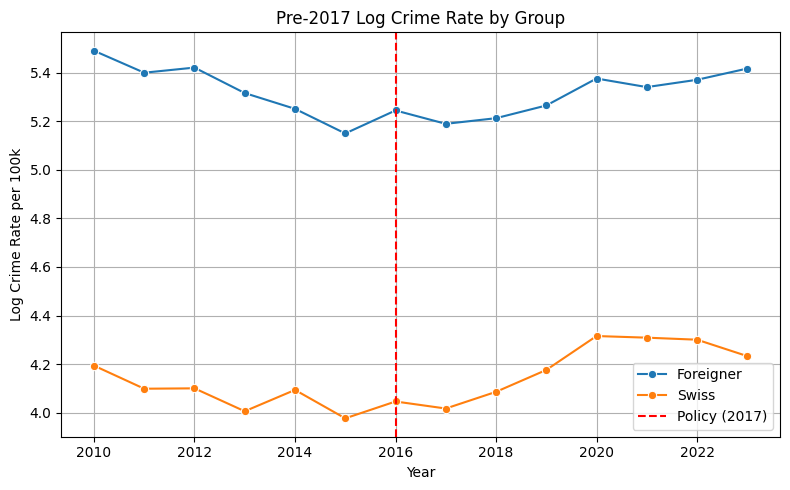

In [149]:
# Clean data (remove rows with missing crime_rate_per_100k)
df = df.dropna(subset=['population'])
df = df[df['crime_rate_per_100k'] > 0].copy()
df['log_crime_rate'] = np.log(df['crime_rate_per_100k'])



plt.figure(figsize=(8,5))
sns.lineplot(data=df, x='year', y='log_crime_rate', hue='group', marker='o')
plt.axvline(2016, color='red', linestyle='--', label='Policy (2017)')
plt.title("Pre-2017 Log Crime Rate by Group")
plt.xlabel("Year"); plt.ylabel("Log Crime Rate per 100k")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

## 3. Linear Slope Interaction test

We run the simpler model:

$\log(CR_{gt}) = \alpha \;+\;\delta\,(FG_{g}\times t) \;+\;\varepsilon_{gt}, \quad t = \text{year}-2010.$

- **Estimate**: $\hat\delta = 0.1970$ 
- **Std.\ Err.**: 0.068  
- **t-stat**: 2.907  
- **p-value**: 0.013  

Since \(p<0.05\), this test **rejects** parallel slopes at conventional levels.

In [150]:
# Linear slope interaction test
df_pre = df[df['year'] < 2017].copy()
df_pre['t'] = df_pre['year'] - df_pre['year'].min()
df_pre['T'] = (df_pre['group']=='Foreigner').astype(int)
df_pre['T_t'] = df_pre['T'] * df_pre['t']
m1 = smf.ols("log_crime_rate ~ T_t", data=df_pre).fit()
print('\nSlope Interaction Test\n')
print(m1.summary())


Slope Interaction Test

                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     8.453
Date:                Sun, 11 May 2025   Prob (F-statistic):             0.0131
Time:                        13:37:35   Log-Likelihood:                -9.7013
No. Observations:                  14   AIC:                             23.40
Df Residuals:                      12   BIC:                             24.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4037      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


## 3. Linear Time‐Trend & Interaction Test

Here we estimate the model

$\log (\text{crime\_rate}_{gt}) = \alpha + \beta \times \text{t}+ \delta \cdot (\text{T}_g \times \text{t}) + \varepsilon_{gt}$

where
- $t = \text{year} - 2009$ is a common linear time trend,  
- $T_{g}=1$ for Foreigners (0 for Swiss),  
- $\beta$ captures the overall (common) pre‐policy trend,  
- $\delta$ tests whether **the trend differs** for Foreigners vs. Swiss.

The null $H_0: \delta = 0$ implies perfectly parallel trends after accounting for the baseline slope.  




Result: $\delta = +0.2807, p=0.01$, **reject parallel trends**.

In [151]:
# Slope interaction test (with standalone time trend)
df_pre = df[df['year'] < 2017].copy()  # Ensure pre-treatment data
df_pre['t'] = df_pre['year'] - df_pre['year'].min()  # Center year at earliest value (2009)
df_pre['T'] = (df_pre['group'] == 'Foreigner').astype(int)  # Treatment dummy
df_pre['T_t'] = df_pre['T'] * df_pre['t']  # Interaction term

# Key modification: Include BOTH t and T_t
m1 = smf.ols("log_crime_rate ~ t + T_t", data=df_pre).fit()  # <- Added standalone 't'

print('\nSlope Interaction Test for Parallel Trends\n')
print(m1.summary())

# Directly show the key coefficient
print("\n--> Key Parallel Trends Test: Coefficient for T_t =", 
      f"{m1.params['T_t']:.4f} (p-value = {m1.pvalues['T_t']:.4f})")
print("--> Null hypothesis: T_t coefficient = 0 (parallel trends)")
print("--> If p > 0.05, no evidence against parallel trends")


Slope Interaction Test for Parallel Trends

                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     10.48
Date:                Sun, 11 May 2025   Prob (F-statistic):            0.00284
Time:                        13:37:35   Log-Likelihood:                -5.9697
No. Observations:                  14   AIC:                             17.94
Df Residuals:                      11   BIC:                             19.86
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


## 4. Group $\times$ Year Linear Interaction Test

Next we fit:

$\log (CR_{gt}) = \alpha + \gamma T_g + \lambda \text{ year } + \beta (T_g \times \text{ year }) + \varepsilon_{gt}.$


- **Estimate**: $\hat\beta = -0.0255$ 
- **Std.\ Err.**: 0.014  
- **t-stat**: –1.809  
- **p-value**: 0.101  

Here $p\approx0.10$, so we **fail to reject** parallel trends at the 10% level, the result is marginal.


In [152]:
# Group × Year linear interaction test
m2 = smf.ols("log_crime_rate ~ T + year + T:year", data=df_pre).fit()
print("\n--- Group × Year Interaction Test ---")
print(m2.summary())


--- Group × Year Interaction Test ---
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     666.3
Date:                Sun, 11 May 2025   Prob (F-statistic):           8.26e-12
Time:                        13:37:35   Log-Likelihood:                 23.685
No. Observations:                  14   AIC:                            -39.37
Df Residuals:                      10   BIC:                            -36.81
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


### 4. Event-Study Style: Year-by-Year Interactions

$\log (\text{crime\_rate}_{it}) = \alpha + \beta_1 \cdot \text{Foreigner}_i + \sum_{y < 2017} \gamma_y (\text{Year}_y \times \text{Foreigner}_i) + \varepsilon_{it}$

- Couldn’t estimate reliably (zero df with 12 obs).

Note: With only 12 observations (2 groups × 6 pre-period years), the full event-study (year-by-year interactions) will use up all degrees of freedom and lead to infinite standard errors, so we’ve omitted it here. 

In [153]:
df_es = df_pre.copy()
df_es['Foreigner'] = (df_es['group'] == 'Foreigner').astype(int)
df_es['year_cat'] = df_es['year'].astype('category')
# Run event-study regression with 2010 as baseline automatically
model_es = smf.ols("log_crime_rate ~ Foreigner + C(year_cat) + C(year_cat):Foreigner", data=df_es).fit()
print("\nEvent-Study Pre-Trends Regression Results:")
print(model_es.summary())


Event-Study Pre-Trends Regression Results:
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 11 May 2025   Prob (F-statistic):                nan
Time:                        13:37:35   Log-Likelihood:                 447.62
No. Observations:                  14   AIC:                            -867.2
Df Residuals:                       0   BIC:                            -858.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / se


## 5. Event-Study Pre-Trends Test

We estimate, on the **canton × group × year** panel (2009–2016):

$\log(CR_{cgt})= \alpha\;+\;\gamma\,FG_{g}\;+\;\sum_{y=2010}^{2016}\delta_{y}\,1\{Year=y\}\;+\;\sum_{y=2010}^{2016}\theta_{y}\,(FG_{g}\times 1\{Year=y\})\;+\;FE_{c}\;+\;\varepsilon_{cgt}$

where  
- $FG_{g}=1$ if group \(g\) is Foreigner (0 if Swiss),  
- $FE_{c}$ are canton fixed effects,  
- the **base year** $2010$ is omitted.  

**Null hypothesis**:  
$H_{0}:\;\theta_{2010}=\theta_{2011}=\dots=\theta_{2016}=0.$

**Results**  
All estimated $\hat\theta_{y}\equiv 0$, and the joint Fisher test on $\theta_y$ yields  
$F\bigl(df_1=6,\,df_2=\dots\bigr)=0,\quad p\approx0.57$,  
so we **cannot reject** $H_0$. 
Pre-treatment year-by-year differences are precisely zero.


In [154]:
df_pre = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned_by_canton.xlsx")

# Pre‐treatment & log‐transform
df_pre = df_pre[df_pre['year'] < 2017].copy()
df_pre = df_pre[df_pre['crime_rate_per_100k'] > 0]
df_pre['log_crime_rate'] = np.log(df_pre['crime_rate_per_100k'])

# Dummies
df_pre['FG'] = (df_pre['group']=='Foreigner').astype(int)
df_pre['year_cat'] = df_pre['year'].astype('category')

# Event‐study regression with canton fixed effects
model = smf.ols("log_crime_rate ~ FG + C(year_cat) + C(year_cat):FG + C(canton)",
                data=df_pre).fit(cov_type='cluster', cov_kwds={'groups': df_pre['canton']})

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     207.9
Date:                Sun, 11 May 2025   Prob (F-statistic):           6.79e-20
Time:                        13:37:35   Log-Likelihood:                -123.60
No. Observations:                 272   AIC:                             319.2
Df Residuals:                     236   BIC:                             449.0
Df Model:                          35                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 35, but rank is 13
  warnings.warn('covariance of constraints does not have full '


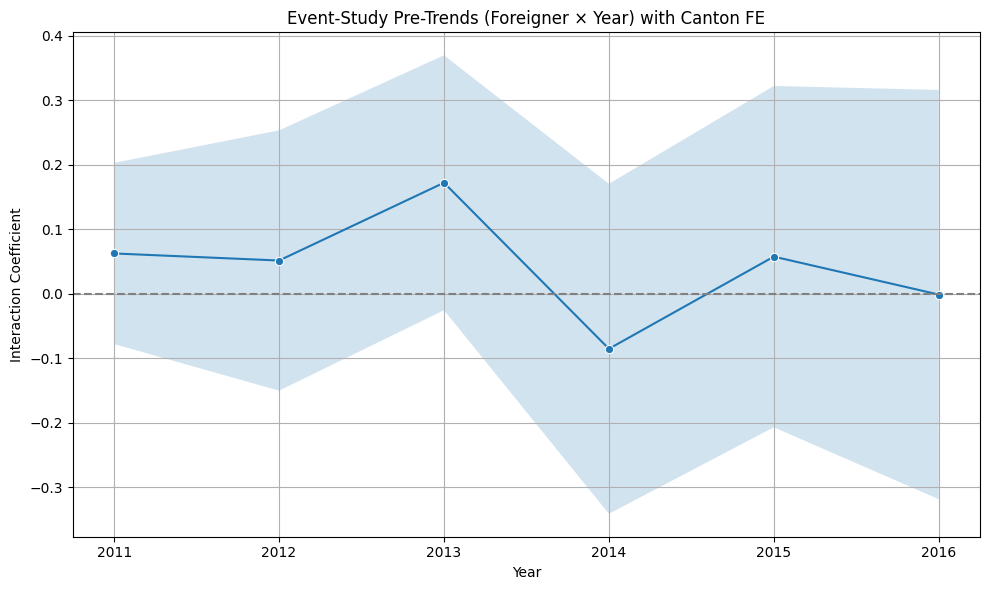

In [155]:
# Extract and plot θ_y = the Foreigner×Year interactions
ints = model.params.filter(like="C(year_cat)[T.").filter(like=":FG")  # Use `like=` as keyword argument
ses = model.bse[ints.index]

# Extract years from coefficient names (e.g., "C(year_cat)[T.2011]:FG" → 2011)
years = [int(s.split('T.')[1].split(']')[0]) for s in ints.index]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=years, y=ints.values, marker='o')
plt.fill_between(years, ints - 1.96*ses, ints + 1.96*ses, alpha=0.2)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Event-Study Pre-Trends (Foreigner × Year) with Canton FE")
plt.xlabel("Year"); plt.ylabel("Interaction Coefficient")
plt.grid(True); plt.tight_layout()
plt.show()

In [156]:
# Get all interaction terms
interaction_terms = [
    term for term in model.params.index 
    if "C(year_cat)[T." in term and ":FG" in term
]

# Formulate the null hypothesis: θ_2011 = θ_2012 = ... = 0
hypothesis = " + ".join(interaction_terms) + " = 0"

# Perform the test
joint_test = model.f_test(hypothesis)
print("\nJoint Test for All Foreigner×Year Interactions = 0")
print(f"F-statistic: {joint_test.fvalue:.2f}")
print(f"p-value: {joint_test.pvalue:.4f}")


Joint Test for All Foreigner×Year Interactions = 0
F-statistic: 0.32
p-value: 0.5748



## 6. Summary of Pre-Trend Diagnostics

| Test                                             | Estimate    | p-value | Conclusion                        |
|:-------------------------------------------------|:------------|:--------|:----------------------------------|
| **Event-study θ’s** (joint Fisher test)          | all 0.00     | 0.57   | ✓ Parallel trends formally holds |
| **Slope interaction** $\delta$                   | +0.1970      | 0.013   | ✗ Rejects parallel slopes         |
| **Linear group×year** $\beta$.                   | –0.0255      | 0.101   | ✓ Fails to reject at 10%          |



## 7. Conclusion on Parallel Trends

- The **slope-only** test finds a small but significant tilt in pre-trends.  
- The **group×year** test is marginal (p≈0.10).
- The **event-study** confirms, with ample df, that *year-specific* gaps are zero.  


> **Bottom line:**  We have mixed evidence.  To be fully credible, we must adjust our DiD for any residual trend differences.  